# Telegram AI bot

This is a model for the <b>Telegram AI bot</b> created with <b>Tensorflow</b>


Importing libraries


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
print(tf.__version__)

2.15.0


In [3]:
# params
IMG_SIZE = (150, 150)
EPOCHS = 50
BATCH_SIZE = 64
train_dir = '/content/animals/train'
test_dir = '/content/animals/val'

# Data processing

Retreiving the dataset. I will use [**Animals**](https://www.kaggle.com/datasets/antobenedetti/animals) dataset
This model was trained in **Colab**


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
!kaggle datasets download -d antobenedetti/animals

 98% 865M/882M [00:04<00:00, 185MB/s]
100% 882M/882M [00:04<00:00, 194MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('/content/animals.zip', 'r') as zip_file:
    zip_file.extractall()

Generating datasets


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_data = train_datagen.flow_from_directory(
    directory=train_dir, target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
val_data = test_datagen.flow_from_directory(
    directory=test_dir, target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


Function to plot random images from the dataset


In [9]:
def plot_random_images_from_dataset(data):
    class_names = list(data.class_indices.keys())

    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_index = data.class_indices[class_name]

        random_index = np.random.choice(
            np.where(data.classes == class_index)[0])

        img_path = data.filepaths[random_index]
        img = plt.imread(img_path)

        axs[i].imshow(img)
        axs[i].set_title(class_name)
        axs[i].axis('off')

    plt.show()

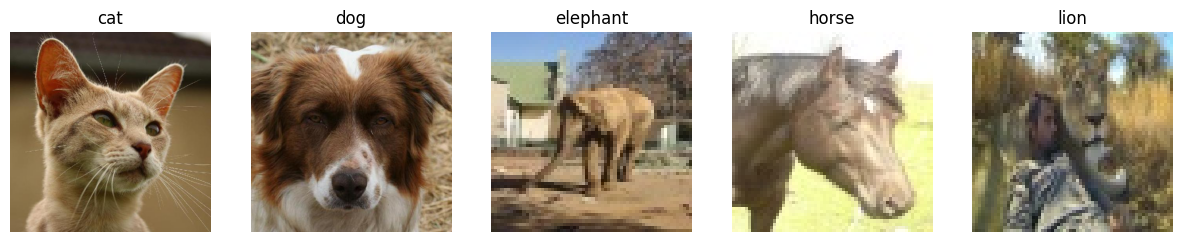

In [10]:
plot_random_images_from_dataset(train_data)

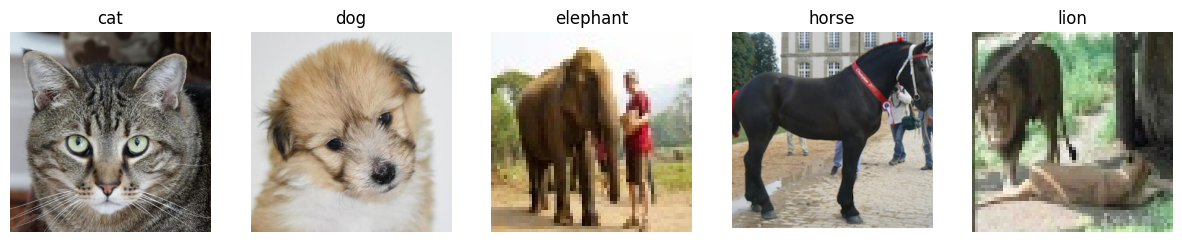

In [11]:
plot_random_images_from_dataset(val_data)

# Model

Now, let's create the model
I will do **Transfer learning**. The base pretrained model will be [**InceptionV3**](https://keras.io/api/applications/inceptionv3/)


In [12]:
pre_trained_model = InceptionV3(
    weights='imagenet', input_shape=(150, 150, 3), include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


Freeze the trained layers


In [13]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [14]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

Getting the _mixed7_ layer. After this layer I will use my layers for my task


In [15]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [17]:
x = layers.Flatten()(last_output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

Compliling the model


In [18]:
model.compile(optimizer="Adam", loss="categorical_crossentropy",
              metrics=['accuracy'])

This is a callback class that will stop training once the accuracy is greater than 99%


In [19]:
import tensorflow as tf


class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

Fit the model


In [20]:
callbacks = MyCallback()
history = model.fit(train_data, validation_data=val_data,
                    verbose=1, epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/50
211/211 [==============================] - 55s 219ms/step - loss: 0.3003 - accuracy: 0.9285 - val_loss: 0.1062 - val_accuracy: 0.9566
Epoch 2/50
211/211 [==============================] - 42s 197ms/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.1253 - val_accuracy: 0.9613
Epoch 3/50
211/211 [==============================] - 42s 199ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.1929 - val_accuracy: 0.9452
Epoch 4/50
211/211 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9941
Reached 99% accuracy so cancelling training!
211/211 [==============================] - 42s 199ms/step - loss: 0.0173 - accuracy: 0.9941 - val_loss: 0.1437 - val_accuracy: 0.9673


Plotting metrics


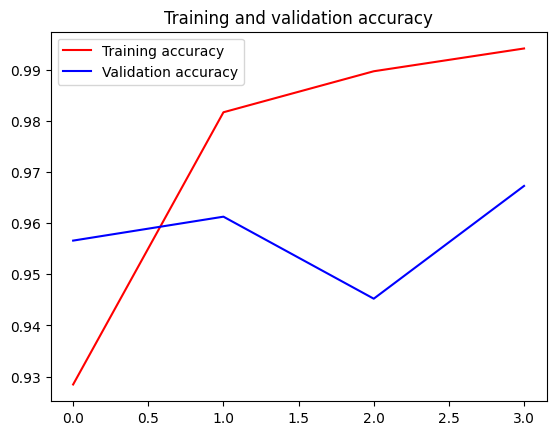

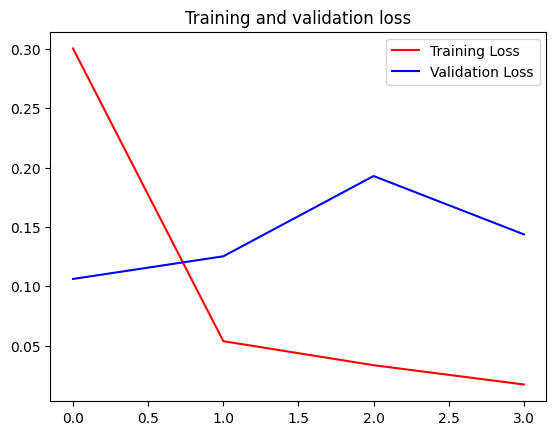

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, save the model


In [22]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# If you use Google Colab you can download the model
def download_model():
    from google.colab import files

    files.download('/content/model.h5')


download_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analyzing results


load our model


In [35]:
from tensorflow.keras.models import load_model
trained_model = load_model('model.h5')

In [36]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

Load the image, then predict the class of the image.
**This cell only works in Colab**


In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():

    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))

    img_array = image.img_to_array(img)
    img_array /= 255

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    print("Вероятности для каждого класса:", predictions)

    predicted_class_index = np.argmax(predictions)
    print(train_data.class_indices)

    class_names = ['cat', 'dog', 'elephant', 'horse', 'lion']
    predicted_class_name = class_names[predicted_class_index]

    print("Predicted class:", predicted_class_name)

Saving funny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg to funny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg
1/1 [==============================] - 0s 24ms/step
Вероятности для каждого класса: [[3.2140645e-06 2.0696930e-10 1.0741301e-13 1.6984729e-02 9.8301202e-01]]
{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}
Предсказанный класс: lion
